### M3 Week 2 Group 8: Daniel Azemar, María Gil, Richard Segovia

## Report structure
First you can find the main code if you want to look the results scroll down

In [2]:
import cv2
import numpy as np
import pickle
from tqdm import tqdm
import random

from sklearn.model_selection import cross_validate, StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import Normalizer, StandardScaler

from assessment import showConfusionMatrix, plot, get_max_key
from descriptors import get_bag_of_words, get_visual_words, compute_descriptors, get_pyramid_visual_word_len, select_descriptors
from classifiers import get_dist_func, select_svm_kernel
from main import save_data, load_data

import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [3]:
class Classification(object):
    def __init__(self):
        # Load train and test files
        self.total_train_images_filenames = pickle.load(open('./train_images_filenames.dat', 'rb'))
        self.total_test_images_filenames = pickle.load(open('./test_images_filenames.dat', 'rb'))
        self.total_train_labels = pickle.load(open('./train_labels.dat', 'rb'))
        self.total_test_labels = pickle.load(open('./test_labels.dat', 'rb'))

        #Cross-validation parameters
        self.split_num = 3 #number of k-folds

        # Descriptors parameters
        self.kp_detector = 'dense' # sift dense
        self.desc_type = 'sift' # sift
        self.n_descriptors = 600

        # Dense SIFT parameters
        self.stepValue = 10
        self.scale_mode = "multiple"  # multiple random, uniform, gauss
        # uniform scale params
        self.maxScale = 15
        self.minScale = 7
        # gauss scale params
        self.mean = 15
        self.desvt = 7

        #BagOfVisualWords parameters
        self.mode_bagofWords = 'all' # all pyramids
        self.reduce_num_of_features = True
        self.features_per_img = 100

        #Spatial pyramid params
        self.levels_pyramid = 2
        self.codebook_size = 128
        self.normalize_level_vw = True
        self.scaleData_level_vw = False

        #Data normalization and scalation
        self.normalize = True
        self.scaleData = False

        #Classifier parameters
        self.classif_type  =  'svm' # knn svm
        self.knn_metric = 'euclidean'
        self.svm_metric = 'hist_intersection' #'rbf' or 'hist_intersection'
        self.save_trainData = False
        #SVM parameters
        self.C=1.0
        self.degree=3
        self.gamma='auto'


    def compute(self):
        # Split train dataset for cross-validation
        cv = StratifiedKFold(n_splits=self.split_num)

        accumulated_accuracy=[]        
        for train_index, val_index in cv.split(self.total_train_images_filenames, self.total_train_labels):
            #train_index = train_index[:200]
            #val_index = val_index[:200]
            train_filenames = [self.total_train_images_filenames[index] for index in train_index]
            train_labels = [self.total_train_labels[index] for index in train_index]
            val_filenames = [self.total_train_images_filenames[index] for index in val_index]
            val_labels = [self.total_train_labels[index] for index in val_index]

            # TRAIN CLASSIFIER
            keypoint_list = []
            train_desc_list = []
            train_label_per_descriptor = []

            for filename, labels in zip(tqdm(train_filenames, desc="train descriptors"), train_labels):
                ima = cv2.imread(filename)
                kpt, des = compute_descriptors(ima, self.kp_detector, self.desc_type, self.stepValue, self.scale_mode, self.minScale, self.maxScale, self.mean, self.desvt, self.n_descriptors)
                keypoint_list.append(kpt)
                train_desc_list.append(des)
                train_label_per_descriptor.append(labels)
            
            D = np.vstack(train_desc_list)

            # reducing the number of descriptors used in bag of words
            if(self.reduce_num_of_features):
                selected_index = select_descriptors(train_desc_list, self.features_per_img)
                D = D[selected_index]

            # 3. Create codebook and fit with train dataset
            codebook, visual_words = get_bag_of_words(self.levels_pyramid, self.mode_bagofWords, D, train_desc_list, keypoint_list, self.codebook_size, normalize_level_vw=self.normalize_level_vw, scaleData_level_vw=self.scaleData_level_vw)

            # 4. self.normalize and scale descriptors
            if(self.normalize):
                norm_model = Normalizer().fit(visual_words) #l2 norm by default
                visual_words = norm_model.fit_transform(visual_words)

            #scaling
            if(self.scaleData):
                scale_model = StandardScaler().fit(visual_words)
                visual_words = scale_model.fit_transform(visual_words)


            # 5. Train classifier
            model = None
            if self.classif_type == 'knn':
                model = KNeighborsClassifier(n_neighbors=5, n_jobs=-1, metric=get_dist_func(self.knn_metric))
                model.fit(visual_words, train_labels)
            elif self.classif_type == 'svm':
                svm_kernel = select_svm_kernel(self.svm_metric)
                model = SVC(C=self.C, kernel=svm_kernel, degree=self.degree, gamma=self.gamma, shrinking=False, probability=False, tol=0.001, max_iter=-1)
                model.fit(visual_words, train_labels)
            else:
                raise (NotImplemented("self.classif_type not implemented or not recognized:" + str(self.classif_type)))

            # 6. Save/load data in pickle
            if self.save_trainData:
                save_data(codebook, "codebook.pkl")
                save_data(visual_words, "visual_words.pkl")
            else:
                pass
                #codebook = load_data("codebook.pkl")
                #visual_words = load_data("visual_words.pkl")

            # VALIDATE CLASSIFIER WITH CROSS-VALIDATION DATASET

            if(self.mode_bagofWords == 'all'):
                visual_words_test = np.zeros((len(val_filenames), self.codebook_size), dtype=np.float32)
            if(self.mode_bagofWords == 'pyramids'):
                len_vw = get_pyramid_visual_word_len(self.levels_pyramid,self.codebook_size)
                visual_words_test = np.zeros((len(val_filenames), len_vw), dtype=np.float32)

            for i in tqdm(range(len(val_filenames)), desc="test descriptors"):
                filename = val_filenames[i]
                ima = cv2.imread(filename)
                kpt, des = compute_descriptors(ima, self.kp_detector, self.desc_type, self.stepValue, self.scale_mode, self.minScale, self.maxScale, self.mean, self.desvt, self.n_descriptors )

                _, visual_words_test[i,:] = get_visual_words(self.levels_pyramid, self.mode_bagofWords, codebook, des, kpt, self.codebook_size,  normalize_level_vw=self.normalize_level_vw, scaleData_level_vw=self.scaleData_level_vw)

            if(self.normalize):
                visual_words_test = norm_model.transform(visual_words_test)
            if(self.scaleData):
                visual_words_test = scale_model.transform(visual_words_test)

            # ASSESSMENT OF THE CLASSIFIER
            accuracy = 100 * model.score(visual_words_test, val_labels)
            accumulated_accuracy.append(accuracy)

            # Show Confusion Matrix
            # showConfusionMatrix(dist_name_list, conf_mat_list, labels_names)

        return np.sum(accumulated_accuracy)/len(accumulated_accuracy)

# Results
**Some of the results depicted in this Notebook where obtained using different machines, and results where afterwards joined for computational expenses reasons.

### Cross-validation
Along the experiments implemented in this report, we used the cross-validation method: StratifiedKFolds, from the scikit-learn library. The number of subsets was set to 3.

In [5]:
#Initialize class Classification() with default parameters
classifier_images = Classification()

### Descriptor extraction improvements
#### Use less descriptors for the kmeans training
When we run Dense SIFT for several scales at each location: [4, 8, 12, 16], we get a great amount of descriptor vectors. Nevertheless, we don't need all of them for the codebook construction and we can select a random subset of them. In this experiment, we set the step value at 12 and we test different amounts of features used for the creation of the codeebok.

In [17]:
#Set experiment parameters
classifier_images.reduce_num_of_features = True
classifier_images.stepValue = 12
features_per_imgs = [10, 50, 100, 250, 500]
results_features_per_img = {}
#Run experiment
for features_per_img in features_per_imgs:
    classifier_images.features_per_img = features_per_img
    results_features_per_img[features_per_img] = classifier_images.compute()
classifier_images.features_per_img = get_max_key(results_features_per_img)

test descriptors: 100%|██████████████████████████████████████████████████████████████| 623/623 [01:10<00:00,  8.94it/s]


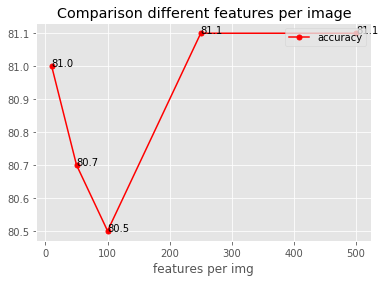

In [3]:
plot(results_features_per_img, title="Comparison different features per image", xlabel="features per img")

Above we see the comparison between the accuracy and the number of keypoints used. We can observe that the larger number of features the larger the accuracy, but from 250 it is not worth the gain with respect to the computational cost. Given the tradeoff between accuracy and computational time, we used 250 keypoints for the rest of the experiments.

#### Use dense sift even more dense
Once we reduced the number of features for the codebook construction, we decided to decrease the step value even more and see if the accuracy obtained versus the computational cost could be worth it.

In [11]:
#Set experiment parameters
step_values = [4, 5, 7, 10, 12]
results_dense_sift = {}
#Run experiment
for step_val in step_values:
    classifier_images.stepValue = step_val
    results_dense_sift[step_val] = classifier_images.compute()
classifier_images.stepValue = get_max_key(results_dense_sift)

test descriptors: 100%|██████████████████████████████████████████████████████████████| 623/623 [01:34<00:00,  6.76it/s]


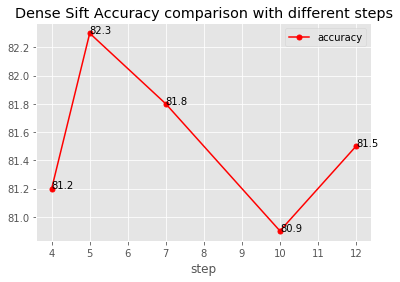

In [4]:
plot(results_dense_sift, title="Dense Sift Accuracy comparison with different steps", xlabel="step")

We were a bit surprised from the results depicted above, specially with respect to the accuracy obtained with step values set at 4 and 12; we decided to dismiss these results and pick the step value at 12, because for any lower value the computational time was too expensive and not worth.

#### Spatial Pyramids
Even with Dense SIFT descriptors, there is a lack of spatial information that can be very useful at classification. In order to preserve this information, we introduced the Spatial Pyramid implementation at the codebook and bag of visual words step. Data is normalized before being stacked, otherwise the resulting descriptors would not have the same relevance depending on their scale.

In [ ]:
#Pyramid levels selection
classifier_images.mode_bagofWords = "pyramid"
levels = [2,3,4]
results_pyramid_levels = {}
#Run experiment
for level in levels:
    classifier_images.levels_pyramid = level
    results_pyramid_levels[subset_size] = classifier_images.compute()
classifier_images.levels_pyramid = get_max_key(results_pyramid_levels)

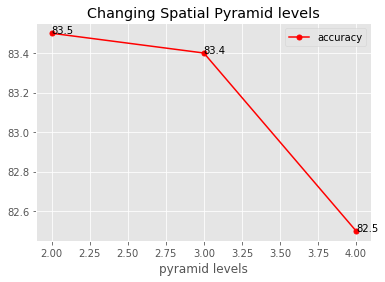

In [10]:
results_pyramid_levels = {2:83.5,3:83.4,4:82.5}
plot(results_pyramid_levels, title="Changing Spatial Pyramid levels", xlabel="pyramid levels")

Using the same parameteres, we can observe that increasing the number of levels of the spatial pyramid does not improve the results. Therefore we chose the number of levels to be 1.

In [15]:
#Analyze improvement introduced by spatial pyramids
classifier_images.mode_bagofWords = "all"
print("not using spatial pyramid accuracy:",classifier_images.compute())

classifier_images.mode_bagofWords = "pyramid"
print("using spatial pyramid accuracy:",classifier_images.compute())

not using spatial pyramid accuracy: 80.39%
using spatial pyramid accuracy: 83.63%


However, even with just one level, spatial pyramids have proved to increase the accuracy with respect to the previous approach.

### Introducing the SVM classifier
#### Parameter selection: cost and gamma
Intuitively, the gamma parameter defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’. The gamma parameters can be seen as the inverse of the radius of influence of samples selected by the model as support vectors.

The C parameter trades off correct classification of training examples against maximization of the decision function’s margin. For larger values of C, a smaller margin will be accepted if the decision function is better at classifying all training points correctly. A lower C will encourage a larger margin, therefore a simpler decision function, at the cost of training accuracy. In other words``C`` behaves as a regularization parameter in the SVM.

In [ ]:
#Set experiment parameters
cost = [0.5,1,2,4]
gamma = 'auto'
results_svm_params = {}
#Run experiment
for c in cost:
    classifier_images.C = c
    results_svm_cost[c] = classifier_images.compute()

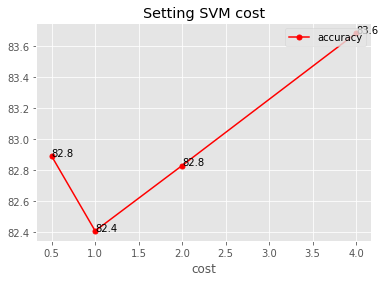

In [11]:
results_svm_cost = {0.5:82.89,1:82.41,2:82.83,4:83.68}
plot(results_svm_cost, title="Setting SVM cost", xlabel="cost")

As it can be observed above, from the cost values chosen for the experiment, the accuracy increases proportionaly with respect to the cost value. Probably we would found that with higher cost values, we would reach a step where the accuracy would decrease again, since the classifier would be overfitting the data. We decided therefore to set the cost value at 4 for the next experiment.

#### Kernel selection: linear, RBF, histogram_intersection
The scikit-learn library provides some tools to find the decision boundary, as the linear or RBF kernel. However, in the case of our data, since we aim to compare histograms, a histogram intersection kernel tool has also been implemented. During this experiment we run a comparison between the three different kernels and provide some analysis.

In [6]:
#Set experiment parameters
kernels = ['linear','rbf','hist_intersection']
results_svm_kernels = {}
#Run experiment
classifier_images.C = 1
classifier_images.mode_bagofWords = "pyramids"
classifier_images.stepValue = 10
for kernel in kernels:
    classifier_images.svm_metric = kernel
    results_svm_kernels[kernel] = classifier_images.compute()
classifier_images.svm_metric = get_max_key(results_svm_kernels)

test descriptors: 100%|██████████████████████████████████████████████████████████████| 623/623 [02:13<00:00,  4.01it/s]


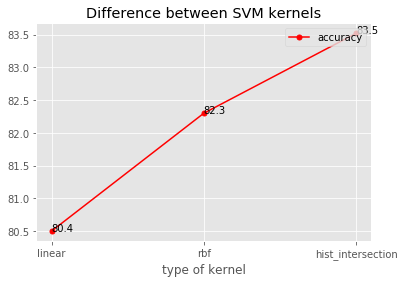

In [9]:
results_svm_kernels = {'linear': 80.499072,'rbf':82.3,'hist_intersection': 83.52097223309693}
plot(results_svm_kernels,title="Difference between SVM kernels", xlabel="type of kernel" )

From the kernel comparison, firstly we can observe that RBF kernel presents better results than the linear kernel: given the characteristics of the data a more complex kernel will better fit the data. Nevertheless, since we are comparing frequency histograms (bag of visual words), the best results are obtained when using the histogram intersection kernel.

### Codebook size selection
When using SVM instead of the KNN classifier, the codebook size plays an important role as well. In the following experiment we iterated over different values for the codebook size and selected the one with the best cross-validated score.

In [ ]:
codebook_sizes = [512, 1024, 2048]

for codebook_size in codebook_sizes:
    classifier_images.codebook_size = codebook_size
    results_codebook_sizes[codebook_size] = classifier_images.compute()
    

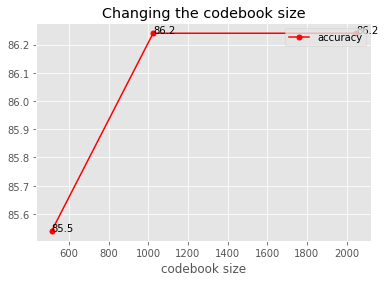

In [13]:
results_codebook_sizes = {512 : 85.54, 1024 : 86.24, 2048 : 86.24 }
plot(results_codebook_sizes,title="Changing the codebook size", xlabel="codebook size" )

The larger the codebook size, the more specific; however increasing too much its size would also ruin the representation of an image, since using too much codewords can smooth the differences between images. Therefore we chose the codebook size to be 1024.

### Use of normalization
Effects of normalizing and/or scaling data before training the classifier

In [ ]:
#Run experiment with and without data normalization
classifier_images.normalize = True
print("Using data normalization accuracy:",classifier_images.compute())

classifier_images.normalize = False
print("Not using data normalization accuracy:",classifier_images.compute())

Using data normalization accuracy:82.62632718814932
Using data normalization accuracy:80.75947939333945

As we can see, the normalization prior to the clustering definitely led to an increase on the accuracy when classifying samples from validation dataset.

## Findings and Conclusions

* Using cross-validation can avoid overfitting the training dataset and is useful for parameter tunning.

* When using DenseSIFT, the lower the step value, the higher the accuracy and the computational time as well.

* When generating the codebook, the larger number of features. Nevertheless, we don't need all of them for the codebook construction and we can select a random subset of them, keeping more or less the accuracy.

* Using Spatial Pyramids as descriptors clearly improves the results, since spatial information is also included.

* Normalizing the data before clustering clearly improves and provides more consistent results.

* The SVM classifier performs better than the KNN classifier.

* Selecting a good cost value for the SVM classifier is important in order to set a good margin for the decision function complexity.

* In the BagOfVisualWords classification problem the SVM kernel that performs better is the histogram intersection kernel, since the structure of the data to compare is a frequency histogram.